In [8]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]
plt.style.use('ggplot')
import os
import pandas as pd
import numpy as np 
import pickle as pk
import glob
from fbprophet import Prophet
import sys
sys.path.append('../')
import wiki
from wiki import utils
from wiki.newphet import load_prophet_prop
import multiprocessing as mp
total_proc = None
from tqdm import tqdm
from IPython.display import clear_output

In [19]:
def load_plot(page, plot_y_org=True):
    forecast = pd.read_feather(PROPHET_PATH+VERSION+page+'df.f')
    print('VERSION',forecast.ds.max())
    wiki.newphet.prophet_plot(forecast, plot_y_org=plot_y_org)
    plt.show()
    forecast = pd.read_feather(PROPHET_PATH+YVERSION+page+'df.f')
    print('YVERSION',forecast.ds.max())
    print('YVERSION train == 0, ds.min()', forecast[forecast.train ==0].ds.min())
    print('YVERSION train == 0, ds.max()', forecast[forecast.train ==0].ds.max())
    wiki.newphet.prophet_plot(forecast, plot_y_org=plot_y_org)
    plt.show()

In [4]:
PROPHET_PATH = '../data/prophet/'
CACHE_PATH = 'cache/'
RESULTS_PATH = 'results/'
VERSION ='v7f/'
YVERSION ='v7fy/'

In [6]:
test_df = pd.read_feather(PROPHET_PATH+RESULTS_PATH+VERSION[:-1]+'df.f'); 
test_df.page_index = test_df.page_index.astype(int)
print(test_df[VERSION[:-1]+'_train'].mean())
test_df = test_df.sort_values(by='page_index').reset_index().drop('index', axis=1)
#test_df = test_df.drop(VERSION[:-1]+'_train', axis=1)
print(test_df.shape)
print(test_df.info())
print(test_df[VERSION[:-1]+'_val'].mean())
test_df.head()

67.2276808221
(145063, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 3 columns):
page_index    145063 non-null int64
v7f_train     145063 non-null float64
v7f_val       0 non-null float64
dtypes: float64(2), int64(1)
memory usage: 3.3 MB
None
nan


,page_index,v7f_train,v7f_val
0,0,45.523519,NaN
1,1,51.148421,NaN
2,2,68.165168,NaN
3,3,44.508590,NaN
4,4,63.366684,NaN


In [7]:
Ytest_df = pd.read_feather(PROPHET_PATH+RESULTS_PATH+YVERSION[:-1]+'df.f'); 
Ytest_df.page_index = Ytest_df.page_index.astype(int)
print(Ytest_df[YVERSION[:-1]+'_train'].mean())
Ytest_df = Ytest_df.sort_values(by='page_index').reset_index().drop('index', axis=1)
#Ytest_df = Ytest_df.drop(VERSION[:-1]+'_train', axis=1)
print(Ytest_df.shape)
print(Ytest_df.info())
print(Ytest_df[YVERSION[:-1]+'_val'].mean())
Ytest_df.head()

65.3604280356
(145063, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 3 columns):
page_index    145063 non-null int64
v7fy_train    145054 non-null float64
v7fy_val      143032 non-null float64
dtypes: float64(2), int64(1)
memory usage: 3.3 MB
None
81.4048967973


,page_index,v7fy_train,v7fy_val
0,0,46.067779,52.132392
1,1,50.509930,44.648623
2,2,69.963561,49.151591
3,3,43.658403,64.134677
4,4,62.534797,155.495860


page_index    95303.000000
v7f_train        31.628062
v7f_val                NaN
Name: 95303, dtype: float64
VERSION 2017-11-13 00:00:00


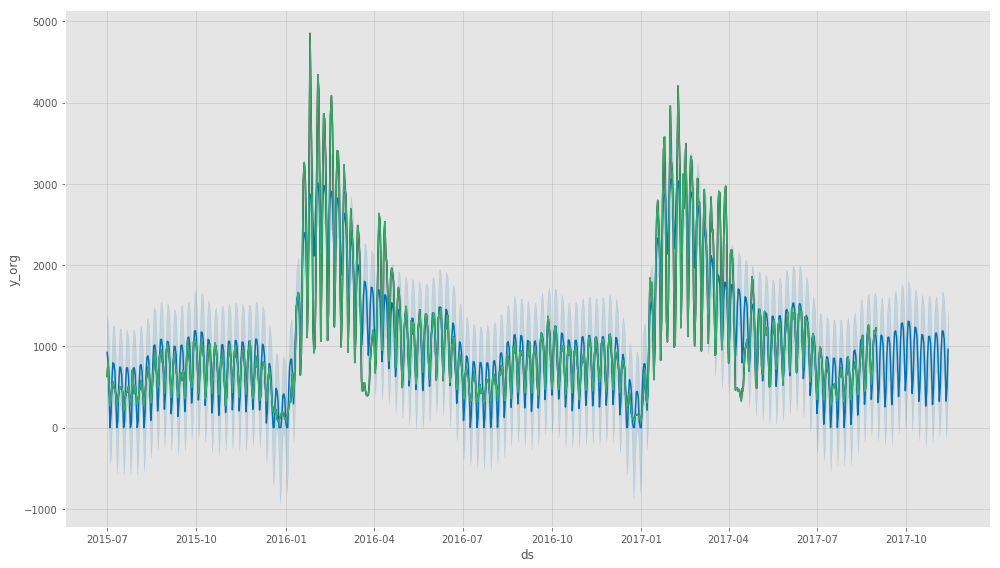

YVERSION 2017-08-31 00:00:00
YVERSION train == 0, ds.min() 2016-09-13 00:00:00
YVERSION train == 0, ds.max() 2016-11-13 00:00:00


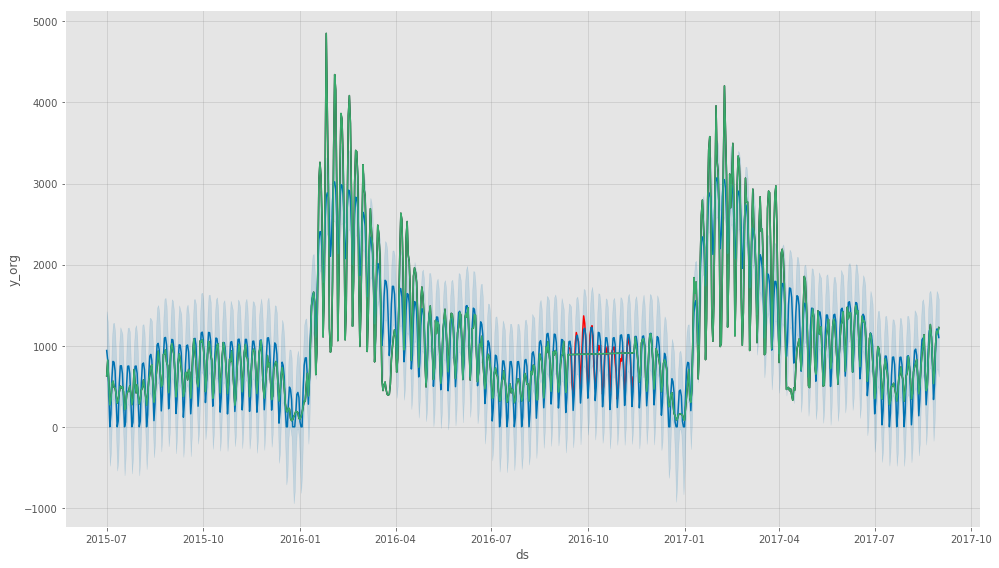

In [25]:
# best
for row in test_df.sample().iterrows():
    print(row[1])
    load_plot(str(int(row[1][0])))

In [12]:
ds = pd.DataFrame(pd.date_range('2017-09-13', '2017-11-13'), columns=['ds']); ds

,ds
0,2017-09-13
1,2017-09-14
2,2017-09-15
3,2017-09-16
4,2017-09-17
5,2017-09-18
6,2017-09-19
7,2017-09-20
8,2017-09-21
9,2017-09-22


In [38]:
median_rolling = wiki.val.load_median_rolling(); median_rolling.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,18,14,11,12,13,12,11,12,13,14,...,20,20,20,21,21,21,21,22,22,22
1,11,12,14,14,14,14,14,14,13,12,...,16,16,16,16,16,16,16,18,18,19
2,1,0,1,1,1,1,1,1,1,1,...,3,3,3,3,3,3,3,3,3,3
3,35,24,13,24,13,20,14,14,13,14,...,14,14,14,14,14,14,14,14,14,14
4,0,0,0,0,0,0,0,0,0,0,...,14,14,14,14,14,14,14,14,15,16


In [36]:
median_rolling.shape

(145063, 793)

In [9]:
df = Ytest_df.merge(test_df, on='page_index'); print(df.shape)
df = df.merge(mediandf, on='page_index'); print(df.shape)
df['Ytest_gain'] = df.prevYear_smape_60_to_0 - df[YVERSION[:-1]+'_val']
df['test_gain'] = df.smape_60_to_0 - df[VERSION[:-1]+'_val']; df.head()

(145063, 5)
(145063, 19)


,page_index,v7ty_train,v7ty_val,v7t_train,v7t_val,Page,median_pred_60,median_pred_120,prevYear_median_pred_60,prevYear_median_pred_120,...,smape_120_to_60,prevYear_smape_60_to_0,prevYear_smape_120_to_60,nans_start_to_120,nans_120_to_60,nans_60_to_0,prevYear_nans_60_to_0,prevYear_nans_120_to_60,Ytest_gain,test_gain
0,0,47.323987,44.956479,46.736751,32.642601,2NE1_zh.wikipedia.org_all-access_spider,24,23,16,17,...,25.959053,40.870388,32.116348,0,0,0,0,0,-12.678048,-0.364169
1,1,48.262866,61.287282,48.666767,83.565553,2PM_zh.wikipedia.org_all-access_spider,24,22,14,17,...,34.415304,60.431899,32.054860,0,0,0,0,0,-18.439419,-40.717689
2,2,71.127792,58.073251,69.758611,120.451293,3C_zh.wikipedia.org_all-access_spider,3,3,4,6,...,65.870407,47.163640,56.748585,0,0,0,0,0,6.232116,-56.145926
3,3,46.191346,52.285567,45.255355,38.493515,4minute_zh.wikipedia.org_all-access_spider,15,19,14,14,...,33.896551,35.401843,49.278494,0,0,0,0,0,-20.035218,-6.243166
4,4,62.962499,132.877882,66.002965,89.498846,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,14,14,3,5,...,38.718059,54.426324,57.220372,291,0,0,0,0,-84.330608,-40.951572


# Magic Feature

In [27]:
median_rolling_smape =  wiki.val.load_test_median_rolling_smape()

median_rolling_smape indexing ::: index -> smape for that following (non_inclusive) 60 days period
(df.smape_60_to_0.fillna(-1) == median_rolling_smape.iloc[:,-60].fillna(-1)).sum() -> 145063


In [28]:
print(median_rolling_smape.iloc[[0],[0,-1]])
print(median_rolling_smape.shape)
median_rolling_smape.head()

   2015-07-01  2017-08-31
0         NaN         NaN
(145063, 793)


,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,NaN,59.292576,47.521198,42.279365,43.644768,45.184539,43.202023,41.268254,42.592001,44.607579,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,73.260387,69.616005,67.684029,68.770630,69.095268,70.576750,71.639287,71.655954,74.052468,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,99.293651,180.000000,99.626984,101.293651,100.341270,100.722222,99.388889,99.388889,99.055556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,88.967936,70.416485,56.959173,69.960825,55.197029,60.669316,53.567910,52.966730,54.192555,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
yhat_rolling_smape =  wiki.val.load_prophet_rolling_smape(VERSION, test_version=False)

AssertionError: 

In [13]:
print(yhat_rolling_smape.iloc[[0],[0,-1]])
print(yhat_rolling_smape.shape)
yhat_rolling_smape.head()

   2015-08-30  2017-08-31
0      46.014         NaN
(145063, 733)


,2015-08-30,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-05,2015-09-06,2015-09-07,2015-09-08,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,46.01400,45.40289,45.30144,44.52684,45.14765,45.53654,46.25179,46.21211,46.71445,45.58791,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,53.50449,53.26103,53.13358,52.39626,52.15095,51.44100,50.79423,51.01956,52.92075,53.88034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,71.58922,71.25588,72.57456,72.46874,72.02430,72.02430,71.74652,72.80472,72.63806,72.16187,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,53.84082,54.01158,53.71279,52.48091,52.18176,52.27033,52.99497,52.96078,53.43351,53.60186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


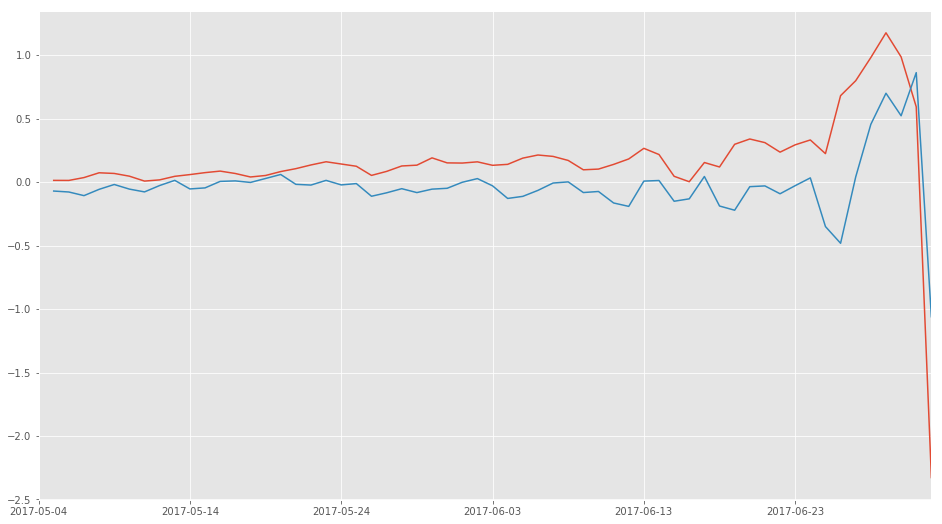

In [19]:
yhat_rolling_smape.iloc[:,-120:-60].diff(1, axis=1).mean(axis=0).plot()
median_rolling_smape.iloc[:,-120:-60].diff(1, axis=1).mean(axis=0).plot()

In [20]:
# remove the yhat smape for the t
yhat_rolling_smape2 = yhat_rolling_smape.copy()
#yhat_rolling_smape2.iloc[:,-120:] = np.nan

In [21]:
cut_off = None
df['rolling_gain_mean'] = (median_rolling_smape.iloc[:,:cut_off] - yhat_rolling_smape2.iloc[:,:cut_off]).mean(axis=1)
df['rolling_gain_std'] = (median_rolling_smape.iloc[:,:cut_off] - yhat_rolling_smape2.iloc[:,:cut_off]).std(axis=1)

In [22]:
print(df['rolling_gain_mean'].max(), df['rolling_gain_mean'].min())
print(df['rolling_gain_std'].max(), df['rolling_gain_std'].min())

200.0 -193.587283558
172.734306215 0.0


In [26]:
df['magic_gain'] = (df['rolling_gain_mean'] - df['rolling_gain_std'] + df['Ytest_gain'])

# Shift preds

In [27]:
y_df = wiki.newphet.load_prophet_prop(VERSION, 'y')

In [28]:
y_df_shift = y_df.shift(365, axis=1)

In [29]:
y_df_shift.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.0,33.0,20.0,14.0,40.0,15.0,18.0,26.0,8.0,25.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.0,10.0,14.0,23.0,15.0,12.0,25.0,22.0,144.0,31.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,2.0,5.0,3.0,2.0,3.0,5.0,4.0,2.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,7.0,18.0,9.0,13.0,27.0,15.0,19.0,7.0,9.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,4.0,3.0,3.0,1.0,3.0,5.0,2.0,3.0,2.0


In [30]:
train = pd.read_feather('../data/train.f')

In [31]:
y_df_smape = wiki.val.get_smape_df(train,y_df_shift)

In [33]:
y_df_smape.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,59.649123,54.945055,22.222222,48.648649,46.153846,103.225806,83.870968,0.000000,100.000000,17.391304
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,69.767442,109.090909,13.333333,29.629630,77.551020,93.333333,24.561404,27.450980,123.595506,21.428571
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.000000,140.740741,138.461538,46.153846,66.666667,146.666667,120.000000,46.153846,100.000000,127.272727
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,123.076923,142.857143,24.390244,61.538462,16.666667,25.000000,28.571429,5.128205,176.068376,50.000000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,168.000000,164.444444,157.142857,152.000000,180.952381,155.555556,141.176471,163.636364,140.000000,169.230769


In [35]:
df['shift_y_smape'] = y_df_smape.iloc[:,-60:].mean(axis=1)

In [36]:
df['shift_y_gain'] = df.smape_60_to_0 - df['shift_y_smape']

# Filter CV

In [39]:
BASE_SCORE = df.smape_60_to_0.mean()

In [40]:
BASE_SCORE

41.043204039840212

In [41]:
df['magic_gain'] = (df['rolling_gain_mean'] - df['rolling_gain_std'] + df['Ytest_gain'])

In [42]:
filter_df = (df['magic_gain'] > 10)
print(len(df[filter_df]))

9748


In [43]:
pd.concat([df[filter_df].v7t_val,
           df[~filter_df].smape_60_to_0]).mean()

41.018080365296257

In [44]:
pd.concat([df[filter_df].shift_y_smape,
           df[~filter_df].smape_60_to_0]).mean()

40.294155675754624

# Saving Results 

In [186]:
# save the pages and val scores
df[filter_df][['page_index','v7t_val']].reset_index().drop('index', axis=1).to_feather(
    #'../data/prophet/results/proph_v7_vals.f')

SyntaxError: unexpected EOF while parsing (<ipython-input-186-199ed2d99082>, line 3)

In [187]:
# save the pages and val scores
# need to grab yhat here I think
yhat[filter_df].iloc[:,-60:].reset_index().rename(columns={'index':'page_index'}).to_feather(
    #'../data/prophet/results/proph_v7_preds.f')

SyntaxError: unexpected EOF while parsing (<ipython-input-187-24f78de871a1>, line 4)